#Cryptocurrency Volatility Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [6]:
import pandas as pd
df = pd.read_csv('dataset.csv')

In [7]:
df

,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,0,112.900002,118.800003,107.142998,115.910004,0.000000e+00,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin,2013-05-05
1,1,3.493130,3.692460,3.346060,3.590890,0.000000e+00,6.229819e+07,2013-05-05T23:59:59.999Z,Litecoin,2013-05-05
2,2,115.980003,124.663002,106.639999,112.300003,0.000000e+00,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin,2013-05-06
3,3,3.594220,3.781020,3.116020,3.371250,0.000000e+00,5.859436e+07,2013-05-06T23:59:59.999Z,Litecoin,2013-05-06
4,4,112.250000,113.444000,97.699997,111.500000,0.000000e+00,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin,2013-05-07
...,...,...,...,...,...,...,...,...,...,...
72941,72941,0.022604,0.022988,0.022197,0.022796,4.040134e+07,1.652957e+09,2022-10-23T23:59:59.999Z,VeChain,2022-10-23
72942,72942,1.468244,1.530464,1.435415,1.517878,2.844351e+07,1.572825e+09,2022-10-23T23:59:59.999Z,Flow,2022-10-23
72943,72943,4.950431,5.148565,4.945280,5.117206,1.069497e+08,1.559551e+09,2022-10-23T23:59:59.999Z,Filecoin,2022-10-23
72944,72944,0.000233,0.000243,0.000226,0.000239,2.143268e+08,1.576291e+09,2022-10-23T23:59:59.999Z,Terra Classic,2022-10-23


In [8]:
print(df.isnull().sum())

Unnamed: 0     0
open           0
high           0
low            0
close          0
volume         0
marketCap      0
timestamp      0
crypto_name    0
date           0
dtype: int64


In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[numerical_cols] = scaler.fit_transform(df[numerical_cols])

minmax_scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[numerical_cols] = minmax_scaler.fit_transform(df[numerical_cols])

print("Standardized Data (Z-score):")
print(df_standardized.head())

print("\nNormalized Data (Min-Max):")
print(df_normalized.head())

Standardized Data (Z-score):
   Unnamed: 0      open      high       low     close    volume  marketCap  \
0   -1.732027 -0.144753 -0.144040 -0.145081 -0.144282 -0.229533  -0.179447   
1   -1.731980 -0.165666 -0.165362 -0.165516 -0.165736 -0.229533  -0.195797   
2   -1.731932 -0.144165 -0.142954 -0.145180 -0.144972 -0.229533  -0.179976   
3   -1.731885 -0.165647 -0.165346 -0.165561 -0.165778 -0.229533  -0.195846   
4   -1.731837 -0.144878 -0.145032 -0.146940 -0.145124 -0.229533  -0.180088   

                  timestamp crypto_name        date  
0  2013-05-05T23:59:59.999Z     Bitcoin  2013-05-05  
1  2013-05-05T23:59:59.999Z    Litecoin  2013-05-05  
2  2013-05-06T23:59:59.999Z     Bitcoin  2013-05-06  
3  2013-05-06T23:59:59.999Z    Litecoin  2013-05-06  
4  2013-05-07T23:59:59.999Z     Bitcoin  2013-05-07  

Normalized Data (Min-Max):
   Unnamed: 0      open      high       low     close  volume  marketCap  \
0    0.000000  0.001671  0.000732  0.001612  0.001715     0.0   0.001011  

In [10]:
df.sort_values(by=["crypto_name", "date"], inplace=True)

df[['open', 'high', 'low', 'close', 'volume', 'marketCap']] = df[['open', 'high', 'low', 'close', 'volume', 'marketCap']].apply(pd.to_numeric, errors='coerce')


grouped = df.groupby('crypto_name')

df['ma_5'] = grouped['close'].transform(lambda x: x.rolling(window=5).mean())
df['ma_10'] = grouped['close'].transform(lambda x: x.rolling(window=10).mean())

df['volatility_5'] = grouped['close'].transform(lambda x: x.rolling(window=5).std())


df['liquidity_ratio'] = df['volume'] / df['marketCap']
df['liquidity_ratio'] = df['liquidity_ratio'].replace([np.inf, -np.inf], np.nan)

rolling_mean = grouped['close'].transform(lambda x: x.rolling(window=20).mean())
rolling_std = grouped['close'].transform(lambda x: x.rolling(window=20).std())
df['bollinger_upper'] = rolling_mean + (rolling_std * 2)
df['bollinger_lower'] = rolling_mean - (rolling_std * 2)

df['true_range'] = grouped.apply(
    lambda g: np.maximum(
        g['high'] - g['low'],
        np.maximum(abs(g['high'] - g['close'].shift(1)), abs(g['low'] - g['close'].shift(1)))
    )
).reset_index(level=0, drop=True)

df['atr_14'] = grouped['true_range'].transform(lambda x: x.rolling(window=14).mean())
df['atrp'] = df['atr_14'] / df['close']

df = df.drop(columns=['true_range'])

print(df[['date', 'crypto_name', 'close', 'ma_5', 'volatility_5', 'liquidity_ratio', 'bollinger_upper', 'bollinger_lower', 'atrp']].tail())

             date crypto_name     close      ma_5  volatility_5  \
72716  2022-09-25         XRP  0.492627  0.390518      0.058509   
72768  2022-10-02         XRP  0.448850  0.409264      0.059342   
72806  2022-10-09         XRP  0.534061  0.444187      0.072595   
72859  2022-10-16         XRP  0.477010  0.467924      0.054698   
72945  2022-10-23         XRP  0.469033  0.484316      0.031970   

       liquidity_ratio  bollinger_upper  bollinger_lower      atrp  
72716         0.139358         0.436159         0.292934  0.058478  
72768         0.068049         0.449625         0.287736  0.069335  
72806         0.067194         0.486827         0.268014  0.068641  
72859         0.043173         0.500654         0.268156  0.083652  
72945         0.040642         0.511045         0.266622  0.082684  


In [11]:
df['close_lag_1'] = df.groupby('crypto_name')['close'].shift(1)
# Drop NaNs and prepare train/test
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = df[['open', 'high', 'low', 'volume', 'marketCap', 'close_lag_1']].dropna()
y = df['close'].loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

model = RandomForestRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [13]:
btc = df[df['crypto_name'] == 'Bitcoin'].set_index('date')
btc = btc['close'].asfreq('D').ffill()

In [15]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

try:
    model = ARIMA(btc, order=(1,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=7)
    print(forecast)
except Exception as e:
    print(f"Model failed: {e}")

2022-10-24    0.0
2022-10-25    0.0
2022-10-26    0.0
2022-10-27    0.0
2022-10-28    0.0
2022-10-29    0.0
2022-10-30    0.0
Freq: D, Name: predicted_mean, dtype: float64


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Sort by crypto and date
df.sort_values(by=['crypto_name', 'date'], inplace=True)

# Predict the next day's closing price
df['target'] = df.groupby('crypto_name')['close'].shift(-1)

# Drop rows with NaN (last row per group will have no future price)
df.dropna(inplace=True)

# Features to use
feature_cols = ['open', 'high', 'low', 'close', 'volume', 'marketCap',
                'ma_5', 'ma_10', 'volatility_5', 'liquidity_ratio', 'bollinger_upper', 'bollinger_lower', 'atrp']

X = df[feature_cols]
y = df['target']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [18]:
model = RandomForestRegressor(n_estimators=10, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [19]:
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

Mean Squared Error: 1028046.91
R-squared Score: 0.98


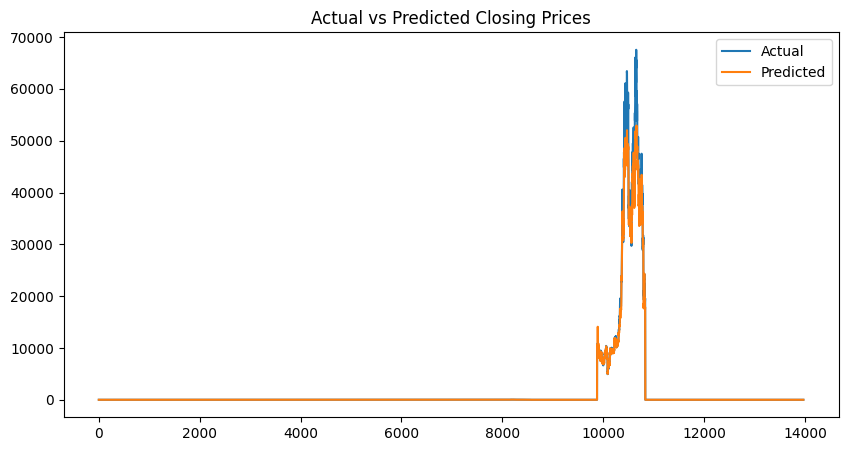

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Closing Prices')
plt.show()